## Project report for Machine Learning (VO) [05.16034]. Professor Alberto Santini, RWTH AACHEN UNIVERSITY, DEUTSCHLAND.

## Contents  
<ol>
    <b><li>Importing necessary libraries</li></b>
    <li><b>Data import and manipulation</b>
        <ol>
            <li>Converting the columns types for the features to float</li>
            <li>Converting the class label types to int</li>
        </ol>
    </li>
    <li><b>Data Analysis and Preprocessing</b>
        <ol>
            <li>Missing Data Analysis
                <ol>
                    <li>Generating Sparsity Matrix for the missing data</li>
                    <li>Generating Heat Map for the missing data</li>
                </ol>
            </li>
            <li>Data Imputation
                <ol>
                    <li>Mean Imputation</li>
                    <li>K-NN</li>
                    <li>EM</li>
                    <li>MICE</li>
                </ol>
            </li>
            <li>Dealing with imbalanced data
                <ol>
                    <li>Oversampling with SMOTE</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Data Modeling</b>
        <ol>
            <li>K-Fold Cross validation</li>
            <li>Models
                <ol>
                    <li>Gaussian Naive Bayes classifier</li>
                    <li>Logistic Regression classifier</li>
                    <li>Decision Tree classifier</li>
                    <li>Random Forest classifier</li>
                    <li>Extreme Gradient Boosting classifier</li>
                    <li>Balanced Bagging classifier</li>
                </ol>
            </li>
        </ol>
    </li>
    <li><b>Model Analysis</b>
        <ol>
            <li>Model ranking</li>
            <li>Balanced Bagging: Effect of varying number of estimators on the accuracy scores on different datasets</li>
            <li>Balanced Bagging: Plotting effect of number of estimators on Accuracy</li>
        </ol>
    </li>
    <li><b>References</b></li>
</ol>

### Importing necessary libraries

In [1]:
# Supressing warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Libraries for data manipulation, statistical operations and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import arff                                                                  # to load .arff files
import missingno as msno                                                                   # to analyze type of missing data
import fancyimpute                                                                         # For performing k-NN and MICE imputations
import impyute as impy                                                                     # For performing Expectation Maximization (EM) imputation
from sklearn.impute import SimpleImputer                                                   # For performing Mean imputation
from sklearn.impute import IterativeImputer                                                # Using this in place of MICE (Multiple Imputation by Chained Equations)

from sklearn.model_selection import KFold                                                  # For performing kFold cross-validation
from collections import Counter                                                            # For counting class objects ( elements as keys, their count as values)
from collections import OrderedDict                                                        # For dictionary operations
from imblearn.over_sampling import SMOTE                                                   # To perform SMOTE oversampling while dealing with imbalanced data

import sklearn
from xgboost import XGBClassifier                                                          # Importing classification models for modeling
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import random

# All metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

### 2. Data import and manipulation

<b>Dataset Link:</b>The Dataset can be found at [Polish bankruptcy dataset](https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data)

There are a total of **5 .arff data files** with the names **`1year`, `2year`, `3year`, `4year`, `5year`**.   
Load the .arff files and convert them into pandas dataframes using the `load_dataframes` function.   
Give them new column headers using the function `set_new_headers`. The column labels for the features are like `X1`, `X2`, ... , `X64`. The class label is `Y`.   
Print the first 5 rows of a dataframe, to see how the data looks like.

In [2]:
# Loads the 5 raw .arff files into a list
def load_arff():
    n = 5
    return [arff.loadarff('data/' + str(i+1) + 'year.arff') for i in range(n)]

# Loads the 5 raw .arff files into pandas dataframes
def init_dataframes():
    return [pd.DataFrame(i_year[0]) for i_year in load_arff()]

# Sets column headers as X1,...X64 and label as Y for all 5 dataframes
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols

# Objects are a list of pandas dataframes for the 5 year datafiles
dataframes = init_dataframes()

# Sets new headers for the dataframes with renamed set of features (X1 to X64) and a label (Y)
set_new_headers(dataframes)

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [3]:
column_list = [dataframes[0].columns]
column_list

[Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
        'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
        'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
        'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
        'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
        'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61',
        'X62', 'X63', 'X64', 'Y'],
       dtype='object')]

#### 2.A Converting the columns types for the features to float
For consistency, we make all python objects as floating points across the dataframe except class label

In [4]:
def convert_to_float(df):
    for i in range(5):
        index = 1
        while index <= 63:
            colname = df[i].columns[index]
            col = getattr(df[i], colname)
            df[i][colname] = col.astype(float)
            index += 1
convert_to_float(dataframes)

#### 2.B Converting the class label types to int
If we look the class label `Y`, we notice that the values are shown either as `b'0'` or `b'1'`   
They actually correspond to bankruptcy being false and true respectively. It is convenient to convert them to binary integers 0 and 1 respectively from objects to int.

In [5]:
def convert_classlabel(df):
    for i in range(len(df)):
        col = getattr(df[i], 'Y')
        df[i]['Y'] = col.astype(int)
        
convert_classlabel(dataframes)

## 3. Data Analysis and Preprocessing
### 3.A Missing Data Analysis

In [24]:
""" Note that our 'dataframes' is actually a list of dataframes for all five years of data"""

class Data:
    
    """ All basic operations we perform on the dataset are created under this class"""
    
    def __init__(self, dataframes):
        """ Initializes the class with dataframes as argument"""
        self.dataframes = dataframes
        
    def drop_missing(self, verbose=False):
        """ Drops the missing values and shows the effects of doing so in numbers"""
        cleaned = [df.dropna(axis=0, how='any') for df in self.dataframes]
        if verbose:
            for i in range(len(self.dataframes)):
                print(str(i+1) + 'year:', 'Original length=', len(self.dataframes[i]), '\tCleaned length = ', len(cleaned[i]), '\tMissing data = ', len(self.dataframes[i] - cleaned[i]))
        else:
            return cleaned
    
    def generate_sparsity_matrix(self):
        """ Generates Sparsity Matrix for the missing data in all dataframes"""
        for i in range(5):
            missing_values = self.dataframes[i].columns[self.dataframes[i].isnull().any()].tolist() # Making a list of all missing values in all 5 dataframes
            msno.matrix(self.dataframes[i][missing_values], figsize=(20,5))
    
    def generate_heatmaps_missing_values(self):
        """ Generates heatmaps for missing values in all dataframes and displays respective correlations among features in a ascending tabular form"""
        for i in range(5):
            missing_values = self.dataframes[i].columns[self.dataframes[i].isnull().any()].tolist() # Making a list of all missing values in all 5 dataframes
            msno.heatmap(self.dataframes[i][missing_values], figsize=(20,20))
    
    def do_mean_imputation(self):
        """ Performs mean imputation method on missing values on all dataframes passed as argument and returns a list of dataframes of same length as of argument"""
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputed_dataframes = [pd.DataFrame(imputer.fit_transform(dfs)) for dfs in self.dataframes]
        for i in range(len(self.dataframes)):
            imputed_dataframes[i].columns = self.dataframes[i].columns
        return imputed_dataframes
    
    def do_knn_imputation(self):
        """ Performs KNN imputation on missing values in all dataframes passed as argument and returns a list of dataframes of same length as of argument"""
        imputed_dataframes = [fancyimpute.KNN(k=100, verbose=True).fit_transform(self.dataframes[i]) for i in range(len(self.dataframes))]
        return [pd.DataFrame(data = imputed_dataframes[i]) for i in range(len(self.dataframes))]
    
    def do_EM_imputation(self):
        """ Performs Expectation Maximization imputation on all dataframes passed as argument and returns a list of dataframes of same length as of argument"""
        imputed_dataframes = [impy.imputation.cs.em(self.dataframes[i].values, loops = 50, dtype = 'cont') for i in range(len(self.dataframes))]
        return [pd.DataFrame(data = imputed_dataframes[i]) for i in range(len(self.dataframes))]
    
    def do_MICE_imputation(self):
        """ Using Sklearn's Iterative Imputer which is inspired by MICE imputer as unable to import MICE imputer module"""
        """ Performs MICE (Multiple Imputation from Chained Equations) on all dataframes passed as argument and returns a list of dataframes of same length as of argument"""
        imputed_dataframes = [IterativeImputer(max_iter=10, random_state=10, verbose=False).fit_transform(self.dataframes[i]) for i in range(len(self.dataframes))]
        return [pd.DataFrame(data = imputed_dataframes[i]) for i in range(len(self.dataframes))]
           
    def set_header(self):
        """ Sets column names for all columns as X1, X2...X63 for all features and Y for label"""
        columns = ['X' + str(i+1) for i in range(len(self.dataframes[0].columns)-1)]
        columns.append('Y')
        for df in self.dataframes:
            df.columns = columns


In [25]:
# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
Data = Data(dataframes)

In [8]:
Data.drop_missing(verbose=True)

1year: Original length= 7027 	Cleaned length =  3194 	Missing data =  7027
2year: Original length= 10173 	Cleaned length =  4088 	Missing data =  10173
3year: Original length= 10503 	Cleaned length =  4885 	Missing data =  10503
4year: Original length= 9792 	Cleaned length =  4769 	Missing data =  9792
5year: Original length= 5910 	Cleaned length =  3031 	Missing data =  5910


Clearly there is a lot of missing data approximately more than 50% of data among features is missing for all dataframes for years (1 to 5). Atleast 1 feature is having missing data.
This is a big problem when dealing with datasets. Let us proceed further and get few insights out of the missing values using our Missing_data() class

#### 3.A.a Generating Sparsity Matrix for the missing data
Finding whether missing data has some correlation is a vital task to perform. The `matrix` function from the `missingno` library helps us generate sparsity matrix, which shows us the gaps in the data.

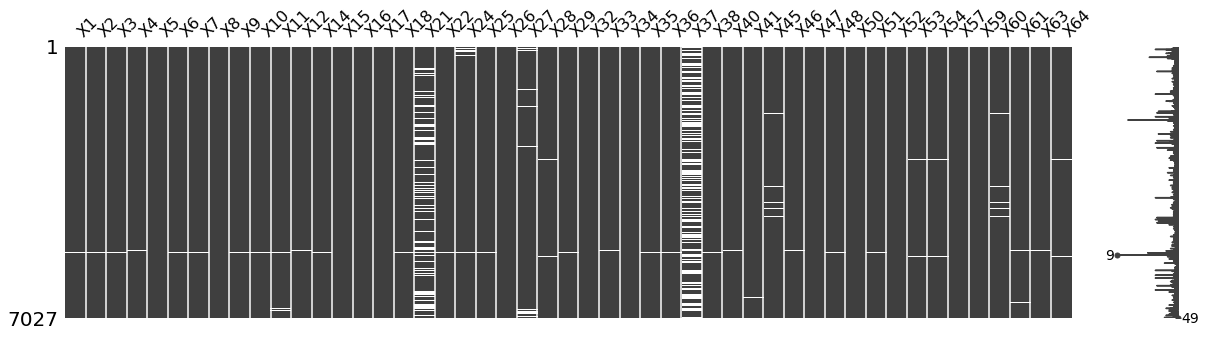

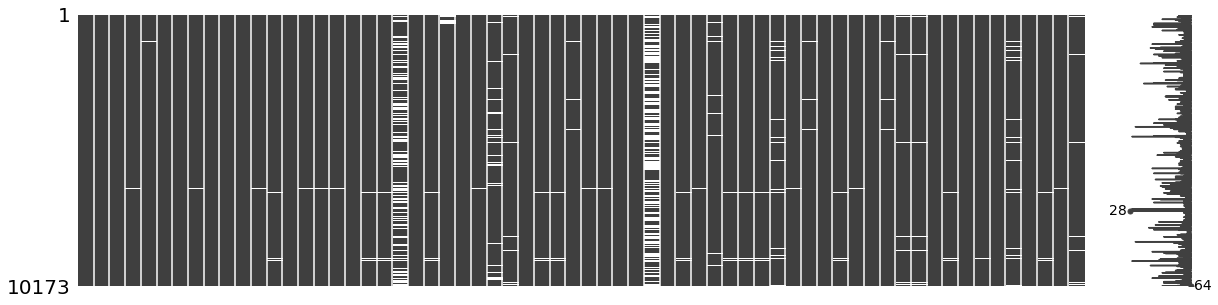

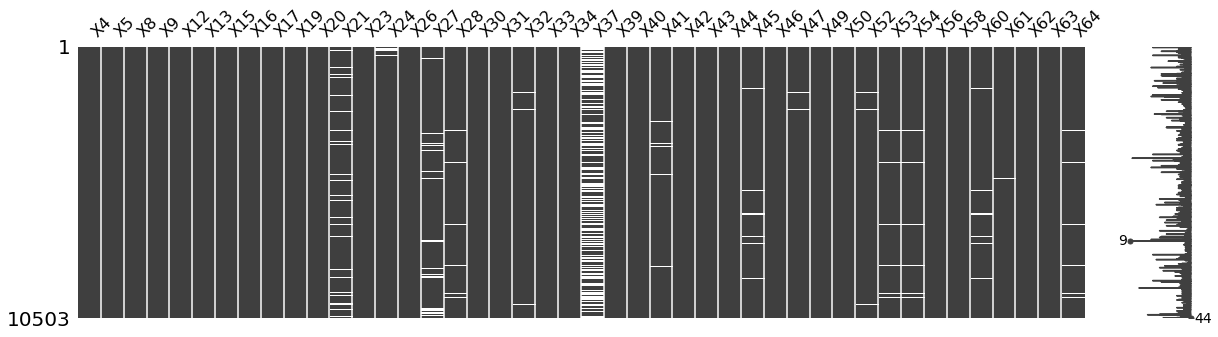

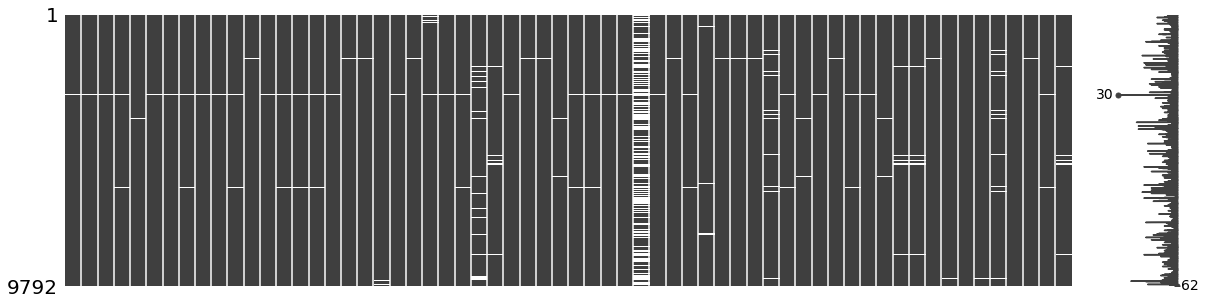

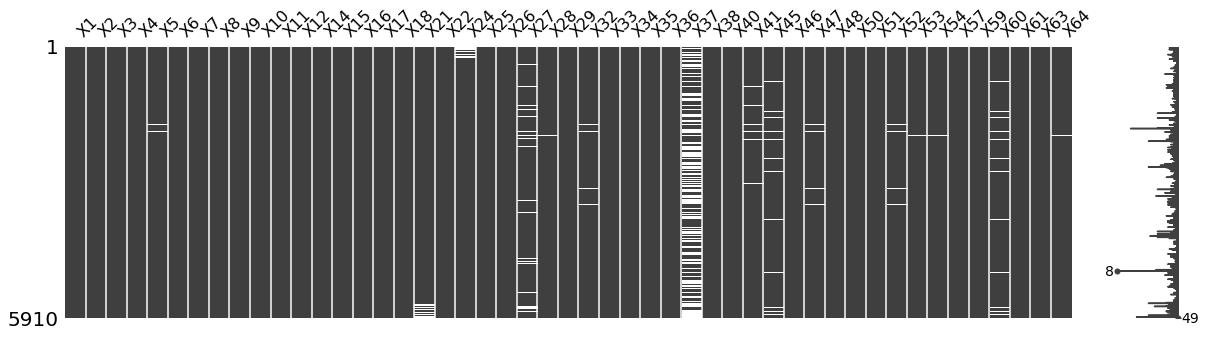

In [9]:
Data.generate_sparsity_matrix()

From the above plots of sparsity for all the 5 dataframes, we could notice a lot of sparsity for the feature `X37` has the highest sparsity among all the features for all the dataframes. The feature `X21` is sparse for some, if not all, dataframes. Also, more or less, all the features have missing data samples. From the above sparsity-plot, we could only know how sparse the data is, yet we don't know if the data missing-ness is correlated among any features, i.e., is the data missing completely at random? Or are there any features that are missing together? as a next step, let us find out if there is some correlation among the features.

However, it is clear that simply dropping all the rows with missing values, or eliminating all the features which have missing values is not a good approach of dealing with the missing data, as it leads to tremendous data loss.

#### 3.A.b Generating Heat Map for the missing data   
Checking if there is some correlation among the missing features.
Using the `heatmap` function from `missingno` library, following are the heatmaps for all dataframes.

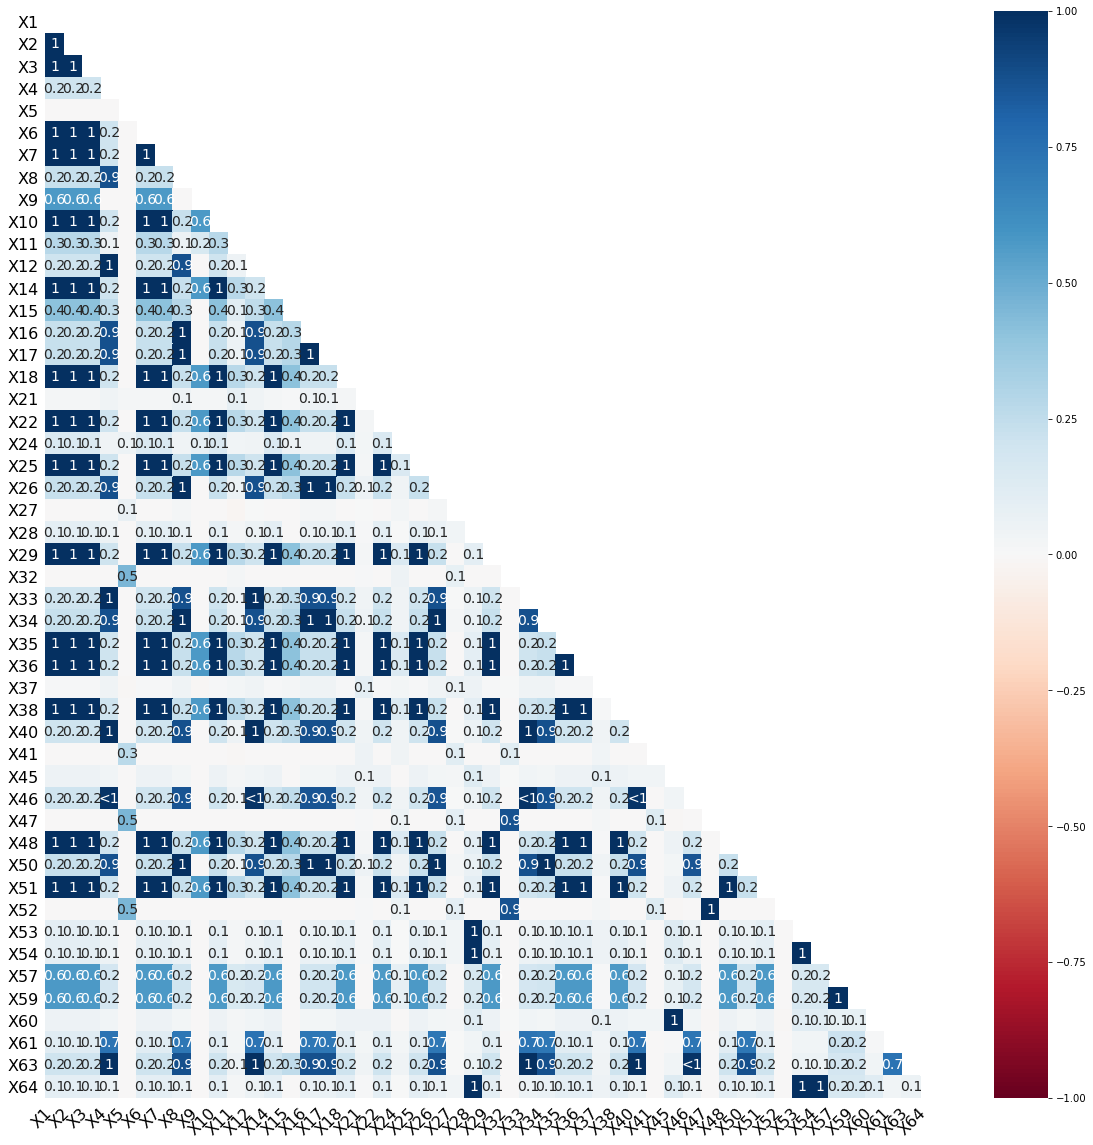

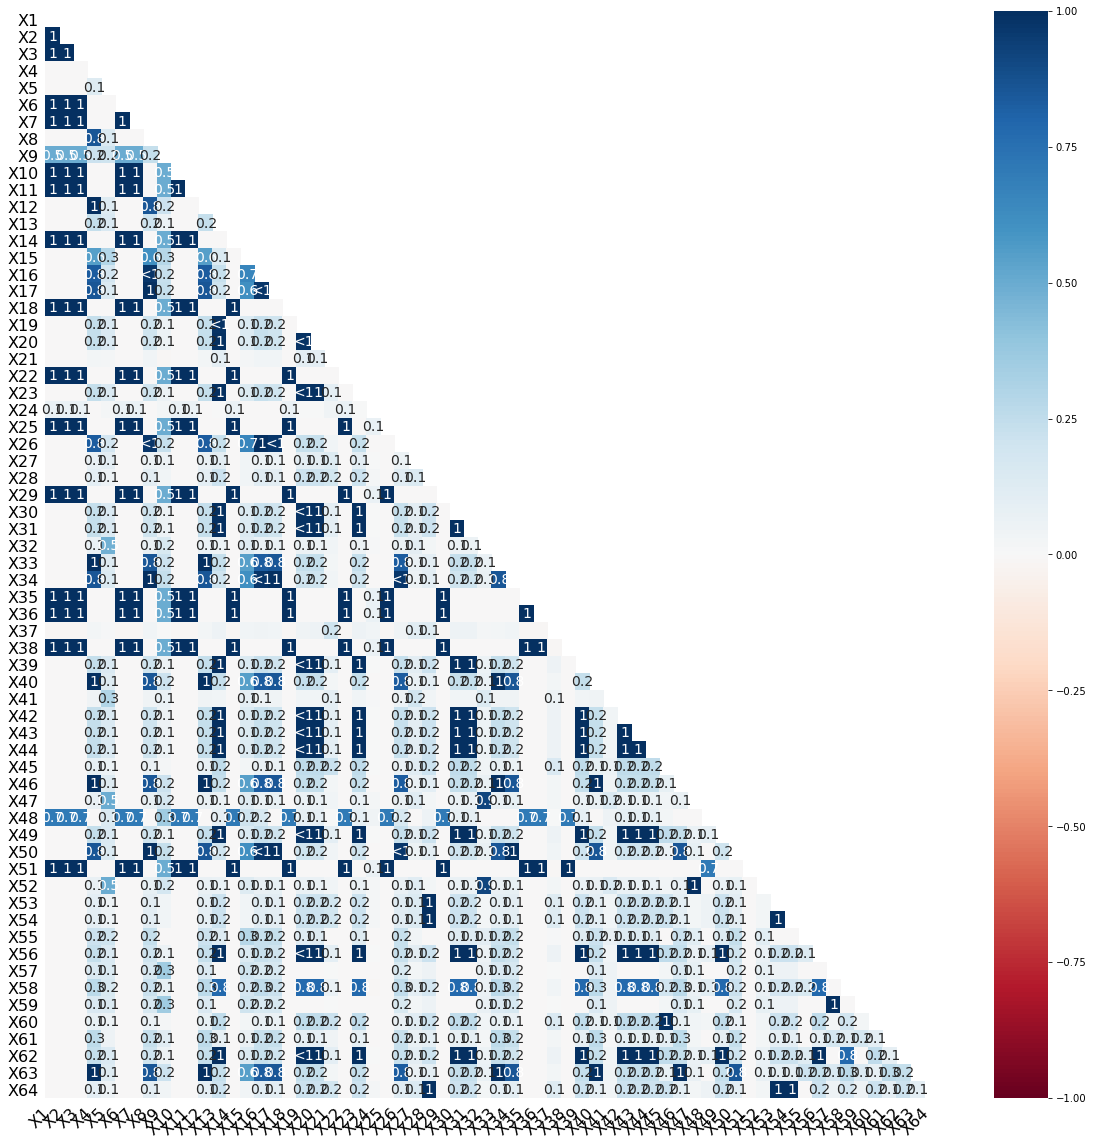

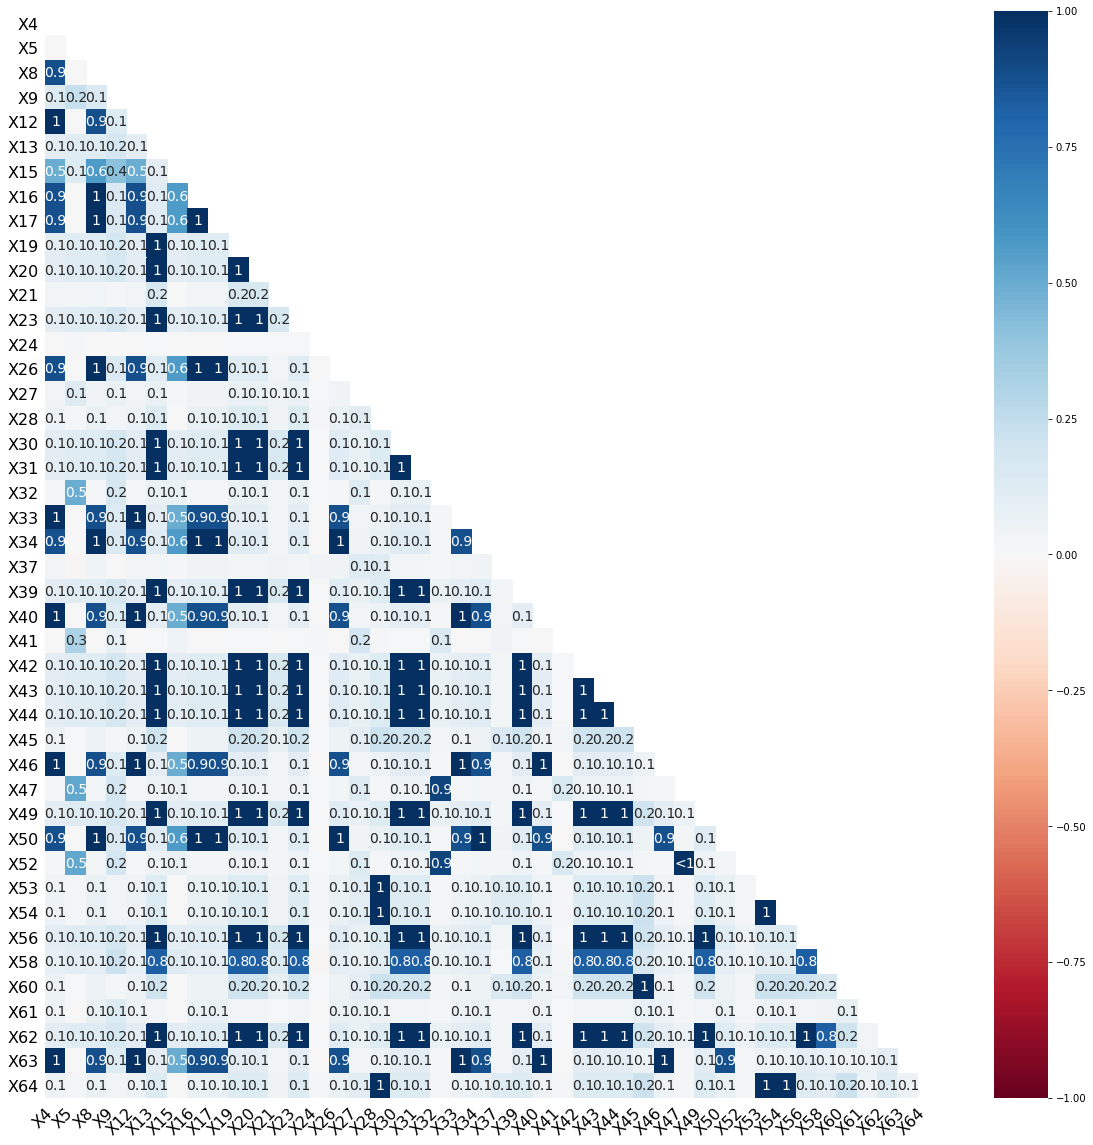

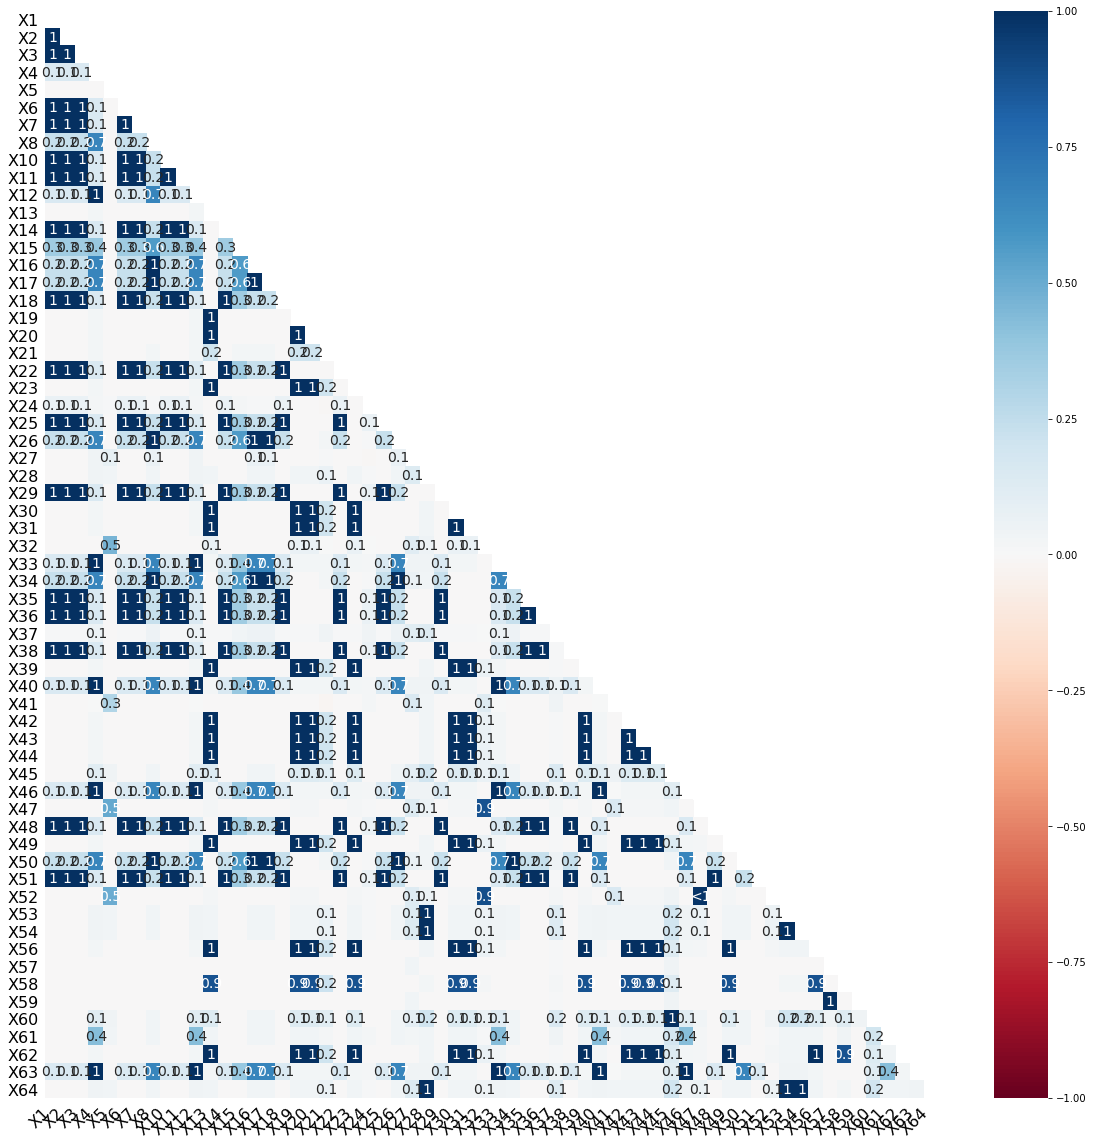

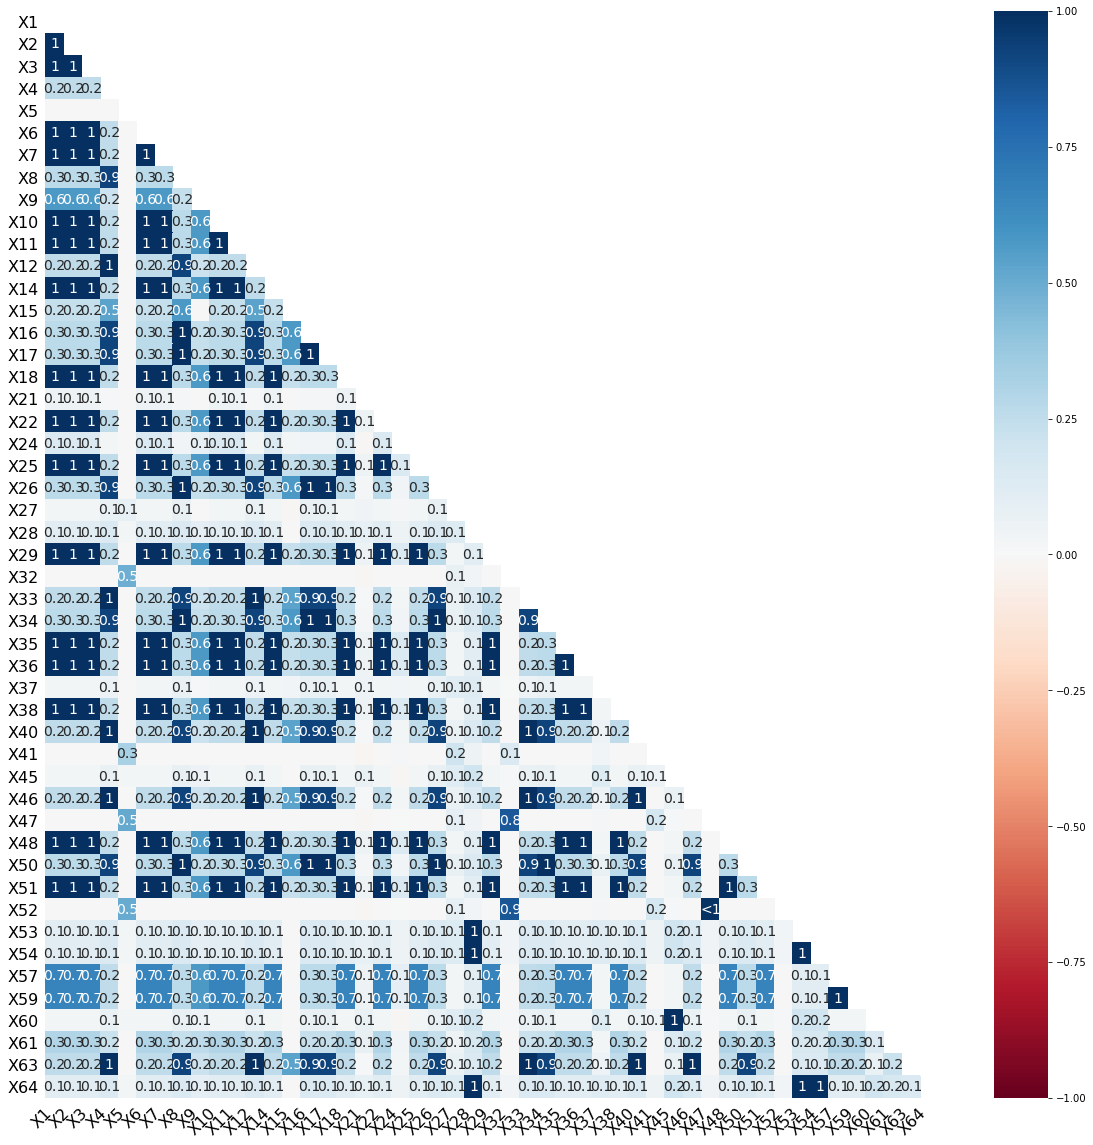

In [10]:
Data.generate_heatmaps_missing_values()

The heat maps above, for all the 5 dataframes, describe the degree of nullity relationship between different features.    The range of this nullity correlation is from -1 to 1 (-1 ≤ R ≤ 1).    
Features with no missing value are excluded in the heatmap. If the nullity correlation is very close to zero (-0.05 < R < 0.05), no value will be displayed.    

A perfect positive nullity correlation (R=1) indicates when the first feature and the second feature both have corresponding missing values.       

A perfect negative nullity correlation (R=-1) means that one of the features is missing and the second is not missing.   

The takeaway is that, in each dataframe, there are some features that are heavily correlated (R = 1 or -1) and also there are features that are not essentially correlated (R values close to 0)

### 3.B Data Imputation

It is now established that we need to impute (fill in the gaps) the missing data, as dropping the missing rows or eliminating the missing features is not an option.   

We would like to explore some of the widely used missing data imputation techniques.   
<b>
1. Mean Imputation (baseline method)
2. k Nearest Neighbors (k-NN) Imputation
3. Expectation-Maximization (EM) Imputation
4. Multivariate Imputation using Chained Equations (MICE)
</b>

#### 3.B.a Mean Imputation

In [11]:
m = Data.do_mean_imputation()

#### 3.B.b k-Nearest Neighbors (k-NN) Imputation

In [12]:
knn = Data.do_knn_imputation()
set_new_headers(knn)

Imputing row 1/7027 with 0 missing, elapsed time: 19.830
Imputing row 101/7027 with 1 missing, elapsed time: 19.836
Imputing row 201/7027 with 2 missing, elapsed time: 19.843
Imputing row 301/7027 with 0 missing, elapsed time: 19.849
Imputing row 401/7027 with 0 missing, elapsed time: 19.854
Imputing row 501/7027 with 1 missing, elapsed time: 19.859
Imputing row 601/7027 with 1 missing, elapsed time: 19.863
Imputing row 701/7027 with 1 missing, elapsed time: 19.868
Imputing row 801/7027 with 0 missing, elapsed time: 19.873
Imputing row 901/7027 with 0 missing, elapsed time: 19.877
Imputing row 1001/7027 with 1 missing, elapsed time: 19.883
Imputing row 1101/7027 with 1 missing, elapsed time: 19.887
Imputing row 1201/7027 with 3 missing, elapsed time: 19.893
Imputing row 1301/7027 with 1 missing, elapsed time: 19.898
Imputing row 1401/7027 with 1 missing, elapsed time: 19.902
Imputing row 1501/7027 with 1 missing, elapsed time: 19.907
Imputing row 1601/7027 with 1 missing, elapsed time:

#### 3.B.c Expectation-Maximization (EM) Imputation

In [26]:
em = Data.do_EM_imputation()
set_new_headers(em)

#### 3.B.d MICE imputation (Multivariate Imputation using Chained Equation)

In [27]:
mice = Data.do_MICE_imputation()
set_new_headers(em)

In the above 4 steps, we have successfully created 4 differently imputed dataframes using: Mean, k-NN, EM and MICE techniques respectively.   

Here below, we create a dictionary of all the imputed dataframes to re-use them in the future. 

In [28]:
imputed_dataframes_dictionary = OrderedDict()
imputed_dataframes_dictionary['Mean'] = m
imputed_dataframes_dictionary['k-NN'] = knn
imputed_dataframes_dictionary['EM'] = em
imputed_dataframes_dictionary['MICE'] = mice

### 3.C Dealing with imbalanced data   

In the steps seen above, we have successfully dealt with the missing data. But we have not dealt with the class imbalance in the data. Data Imbalance is a condition where the samples belonging to one or more 'majority' class labels of a labelled dataset heavily outnumber the sample belonging to the other 'minority' classes.   

Data imbalance critically affects the modeling as the models won't have sufficient data belonging to minority classes to train on and this leads to biased models, ultimately leading to poor performance on test data.   

Examining severity of imbalance....

In [29]:
def data_imbalance(dataframes):
    for i in range(len(dataframes)):
        print('Dataset: '+str(i+1)+' ndyear')
        print(dataframes[i].groupby('Y').size())
        minority_percent = (dataframes[i]['Y'].tolist().count(1) / len(dataframes[i]['Y'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
        print('-'*64)
        
data_imbalance(dataframes)

Dataset: 1 ndyear
Y
0    6756
1     271
dtype: int64
Minority (label 1) percentage: 3.856553294435748%
----------------------------------------------------------------
Dataset: 2 ndyear
Y
0    9773
1     400
dtype: int64
Minority (label 1) percentage: 3.931976801336872%
----------------------------------------------------------------
Dataset: 3 ndyear
Y
0    10008
1      495
dtype: int64
Minority (label 1) percentage: 4.712939160239932%
----------------------------------------------------------------
Dataset: 4 ndyear
Y
0    9277
1     515
dtype: int64
Minority (label 1) percentage: 5.259395424836601%
----------------------------------------------------------------
Dataset: 5 ndyear
Y
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917%
----------------------------------------------------------------


There is a lot of data imbalance for our datasets, as indicated by the percentage of minority class (label `1`) samples among their datasets. This huge magnitude of data imbalance will not train models well.

#### 3.C.a Oversampling with SMOTE (Synthetic Minority Over Sampling Technique)

In [30]:
class OVERSAMPLING:
    
    """ Contains all methods required for performing SMOTE oversampling.........__init__(self) not required"""

    def split_dataframes_features_labels(self,dfs):
        """ Split the features and labels into separate dataframes for all the original dataframes """ 
        feature_dataframes = [dfs[i].iloc[:,0:64] for i in range(len(dfs))]
        label_dataframes = [dfs[i].iloc[:,64] for i in range(len(dfs))]
        return feature_dataframes, label_dataframes    
    
    
    def oversample_data_SMOTE(self,dfs, verbose=False):
        """ Performs oversampling for dataframes passed in as an argument"""
        smote = SMOTE('auto' , random_state=42, k_neighbors=10)
        #Split the features and labels for each dataframe
        feature_dataframes, label_dataframes = self.split_dataframes_features_labels(dfs)
        resampled_feature_arrays = []
        resampled_label_arrays = []
        for i in range(len(dfs)):
            if verbose: print('Dataset: ' + str(i+1) + 'year:')
            if verbose: print('Original dataset shape {}'.format(Counter(label_dataframes[i])))
            dfi_features_res, dfi_label_res = smote.fit_sample(feature_dataframes[i], label_dataframes[i])
            if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
            # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
            resampled_feature_arrays.append(dfi_features_res)
            resampled_label_arrays.append(dfi_label_res)        
        return resampled_feature_arrays, resampled_label_arrays

    
    def restructure_arrays_to_dataframes(self, feature_arrays, label_arrays):  
        """ Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them. Also re-assign the columns headers """
        resampled_dfs = []
        for i in range(len(feature_arrays)):
            feature_df = pd.DataFrame(data=feature_arrays[i])
            label_df = pd.DataFrame(data=label_arrays[i])
            # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
            label_df.columns=['Y'] 
            resampled_dfs.append(feature_df.join(label_df))
        # re-assign the column headers for features and labels    
        self.set_headers(resampled_dfs)
        return resampled_dfs

    def set_headers(self,dataframes):
        cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
        cols.append('Y')
        for df in dataframes:
            df.columns = cols


    def perform_oversampling_on_imputed_dataframes(self, df_dict):
        """ Performs SMOTE on all imputed dataframes and stores them in a dictionary"""
        imputed_oversampled_dataframes_dictionary = OrderedDict()
        for key,dfs in df_dict.items():
            print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
            smote_feature_arrays, smote_label_arrays = self.oversample_data_SMOTE(dfs, verbose=True)
            oversampled_dataframes = self.restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
            imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
            print('-'*100)
        return imputed_oversampled_dataframes_dictionary


In [31]:
imputed_oversampled_dataframes_dictionary = OVERSAMPLING().perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)

SMOTE Oversampling for Mean imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape Counter({0.0: 9773, 1.0: 400})
Resampled dataset shape Counter({0.0: 9773, 1.0: 9773})

Dataset: 3year:
Original dataset shape Counter({0.0: 10008, 1.0: 495})
Resampled dataset shape Counter({0.0: 10008, 1.0: 10008})

Dataset: 4year:
Original dataset shape Counter({0.0: 9277, 1.0: 515})
Resampled dataset shape Counter({0.0: 9277, 1.0: 9277})

Dataset: 5year:
Original dataset shape Counter({0.0: 5500, 1.0: 410})
Resampled dataset shape Counter({0.0: 5500, 1.0: 5500})

----------------------------------------------------------------------------------------------------
SMOTE Oversampling for k-NN imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 6756, 1.0: 271})
Resampled dataset shape Counter({0.0: 6756, 1.0: 6756})

Dataset: 2year:
Original dataset shape

## 4. Data Modeling: Building Classification Models

### 4.A K-Fold Cross Validation

In [32]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

### 4.B MODELS

### 4.B.a Gaussian Naive Bayes classifier

In [45]:
# Gaussian Naive Bayes classifier
gnb_classifier = GaussianNB()

### 4.B.b Logistic Regression classifier

In [54]:
# Logistic Regression classifier
lr_classifier = LogisticRegression(penalty = 'l1', random_state = 0, solver='liblinear')

### 4.B.c Decision Tree Classifier

In [55]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

### 4.B.d Random Forest Classifier

In [56]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy')

### 4.B.e Extreme Gradient Boosting Classifier

In [57]:
# eXtreme Gradient Boosting Classifier (XGBClassifier)
xgb_classifier = XGBClassifier()

### 4.B.f Balanced Bagging Classifier

In [58]:
# Balanced Bagging Classifier
bb_classifier = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = 5, bootstrap = True)

In [59]:
# creating a dictionary of models
models_dictionary = OrderedDict()

models_dictionary['Gaussian Naive Bayes'] = gnb_classifier
models_dictionary['Logistic Regression'] = lr_classifier
models_dictionary['Decision Tree'] = dt_classifier
models_dictionary['Extreme Gradient Boosting'] = xgb_classifier
models_dictionary['Random Forest'] = rf_classifier
models_dictionary['Balanced Bagging'] = bb_classifier

In [60]:
# perform data modeling
def perform_data_modeling(_models_, _imputers_, verbose=False, k_folds=5):
    
    # 7 Models
    # 4 Imputers
    # 5 datasets (for 5 years)
    # 7 metrics, averaged over all the K-Folds
    model_results = OrderedDict()
    
    # Iterate over the models
    for model_name, clf in _models_.items():
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms (Mean, k-NN, EM, MICE)
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                precision_list = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])                
                
                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    
                    # Fit the model and 
                    clf = clf.fit(X_train, y_train)
                    y_test_predicted = clf.predict(X_test)
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    
                    #code for calculating confusion matrix 
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results

In [61]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)

------------------------------------------------------------------------------------------------------------------------ 
 Model: Gaussian Naive Bayes Classifier
	Imputer Technique: Mean
		Dataset: 1year
			Accuracy: 0.5156118171190658
			Precision: [0.55384615 0.50140311]
			Recall: [0.02427755 0.59385805]
		Dataset: 2year
			Accuracy: 0.512558257912261
			Precision: [0.50166667 0.50007918]
			Recall: [0.02522294 0.5874152 ]
		Dataset: 3year
			Accuracy: 0.5196079463878615
			Precision: [0.53333333 0.50124288]
			Recall: [0.03492381 0.58701092]
		Dataset: 4year
			Accuracy: 0.5144681833930015
			Precision: [0.51151515 0.50056402]
			Recall: [0.03805172 0.5774183 ]
		Dataset: 5year
			Accuracy: 0.517090909090909
			Precision: [0.51764706 0.50100913]
			Recall: [0.04245455 0.57654545]
	Imputer Technique: k-NN
		Dataset: 1year
			Accuracy: 0.5167952761317647
			Precision: [0.54647887 0.50133029]
			Recall: [0.0268676  0.59230408]
		Dataset: 2year
			Accuracy: 0.5118931523358452
			Precis

KeyboardInterrupt: 

## Model Analysis

### Model Ranking

In [ ]:
# model -> imputer -> year
def perform_model_ranking(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [ ]:
perform_model_ranking(models_dictionary, imputed_oversampled_dataframes_dictionary, results)

### Balanced Bagging: Effect of varying number of estimators on the accuracy scores on different datasets

In [ ]:
# This list stores results of Balanced Bagging classifier obtained by running it for 
# various values of number of estimators in the range of 1 to 30
results_by_estimators = []
for i in range(29):
    models_dictionary['Balanced Bagging'] = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = i+1, bootstrap = True)
    results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, verbose=True, k_folds=5)
    results_by_estimators.append(results) 

### Balanced Bagging: Plotting effect of number of estimators on Accuracy 

In [ ]:
year1_values = []
year2_values = []
year3_values = []
year4_values = []
year5_values = []

# extract corresponding Balanced bagging with Mean imputation
# classification metrics 
def extract_actual_values_from_dict(curr_dict):
    temp_dict = curr_dict['Balanced Bagging']
    return temp_dict['Mean']

for i in range(29):
    curr_dict = results_by_estimators[i]
    curr_result = extract_actual_values_from_dict(curr_dict)
    
        
    year_1_result = curr_result['1year']
    year_2_result = curr_result['2year']
    year_3_result = curr_result['3year']
    year_4_result = curr_result['4year']
    year_5_result = curr_result['5year']
    year1_values.append(year_1_result['Accuracy'])
    year2_values.append(year_2_result['Accuracy'])
    year3_values.append(year_3_result['Accuracy'])
    year4_values.append(year_4_result['Accuracy'])
    year5_values.append(year_5_result['Accuracy'])

### Plot of effect of number of estimators on Accuracy for Balanced Bagging classifier

In [ ]:
import matplotlib.pyplot as plt

estimators = [i+1 for i in range(29)] 

# plot year1, year2, year3, year4 and year5 accuracy values
# for range of estimator values from 1 to 30
plt.plot(estimators, year1_values, '.b-')
plt.plot(estimators, year2_values, '.r-')
plt.plot(estimators, year3_values, '.y-')
plt.plot(estimators, year4_values, '.g-')
plt.plot(estimators, year5_values, '.m-') 
plt.xlabel("\nNumber of estimators")
plt.ylabel("Accuracy")
plt.title("\nEffect of varying number of estimators on the accuracy scores on different datasets\n")

# display legend
plt.plot(10, 0.93, '.b-', label='Year 1')
plt.plot(10, 0.93, '.r-', label='Year 2')
plt.plot(10, 0.93, '.y-', label='Year 3')
plt.plot(10, 0.93, '.g-', label='Year 4')
plt.plot(10, 0.93, '.m-', label='Year 5')

plt.legend(loc='lower right')

## References
https://docs.scipy.org/doc/numpy-1.14.0/reference/
https://pandas.pydata.org/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.arff.loadarff.html
https://github.com/iskandr/fancyimpute
https://pypi.org/project/impyute/
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://docs.python.org/3/library/collections.html
http://xgboost.readthedocs.io/en/latest/python/python_api.html
http://scikit-learn.org/stable/modules/svm.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.ensemble.BalancedBaggingClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
https://docs.python.org/2/library/random.html
http://scikit-learn.org/stable/modules/classes.html
_______________________________________________________________________________
#### _____________END OF PROJECT_____